In [1]:
using Revise
using SeisMain, SeisPlot, SeisProcessing
using FFTW, LinearAlgebra, PyPlot

# Developing packages
using IterativeMethods
using HCDSP
using snr

┌ Info: Recompiling stale cache file /home/bbahia/.julia/compiled/v1.0/snr/KdaIM.ji for snr [cfb3a92c-1d4c-11eb-2a4b-9dd6bdbf77d6]
└ @ Base loading.jl:1190


Loaded


In [17]:
# Source position
sx = 540; sy = 204;

# Receivers and offset
nx = 50;  ny = 5;
rx = zeros(nx*ny);
ry = zeros(nx*ny);
 h = zeros(nx*ny);

k = 0;
for il in 1:ny, xl in 1:nx
     k = k+1;
     ry[k,1] = (il-1)*150 + randn()*5.0;
     rx[k,1] = (xl-1)*25  + randn()*5.0;
      h[k,1] = sqrt( (rx[k,1]-sx)^2 + (ry[k,1]-sy)^2 );
end   

nh = length(h)

250

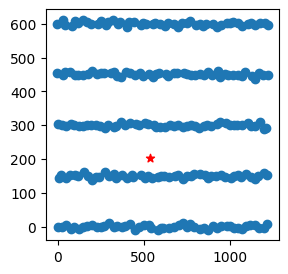

PyObject <matplotlib.collections.PathCollection object at 0x7f59a1c9af60>

In [18]:
fig = figure("Source-receiver",figsize=(3,3))

scatter(rx,ry)
scatter(sx,sy,color="red",marker="*")

In [19]:
function irregular_hyperbolic_events(dt,nt,h,tau,vel,amp,f0,fmin,fmax)
    
    # Padding and allocation
    nfft = (2 * nextpow(2, nt));
    
    # Offsets and events
    nh = length(h)
    ns = length(vel)
    
    # Allocation
    OUT  = zeros(nt,nh)
    OUTF = complex.(zeros(nfft,nh))
    
    # Wavelet
    wav = complex.(snr.Ricker(dt = dt, f0 = f0))
     nw = length(wav);
    append!(wav,zeros(nfft-nw))
    fft!(wav)
    
    # Freq range
    ω_range = freq_indexes(fmin,fmax,dt,nfft)
    
    # Imaginary unit
    im = complex(0,1)
    
    # Loop over (positive) freqs
    @inbounds for iω in ω_range
        # Freq
        f = (iω-1)/nfft/dt;
        ω = 2*pi*f;
        
        Ac = complex.(zeros(nh,ns))
        for i in 1:nh, j in 1:ns
             t = sqrt(tau[j]^2 + (h[i] / vel[j])^2); 
             Ac[i,j] = exp(-im*ω*t);
        end                                   
        
        # Coefficients
        m = wav[iω] .* amp;
        
        # Output
        OUTF[iω,:] .= Ac*m;
    end
    
    # Symmetries
    conj_symmetry!(OUTF);
    
    # ifft and truncation
    OUT = real( ifft!(OUTF,1) )[1:nt,:];

    # Return
    return OUT 
end

irregular_hyperbolic_events (generic function with 1 method)

In [20]:
# Parameters for P-wave hyperbolas
dt = 2/1000;
nt = 1001;
f0 = 20; fmin,fmax=0,100;
tau = [0.3, 0.39,  0.5, 0.6,  0.83,  1.2];       # intercept of hyperbolas P wave    
amp = [1.0, 0.8,  -1.0, 1.1, -0.9,   0.6];       # amplitude of hyperbolas (signal)
vel = [2.0, 2.4,   3.0, 3.4,  3.4,   4.0]*1000;  # rms velocity of hyperbolas (signal)   
apex = zero(vel);

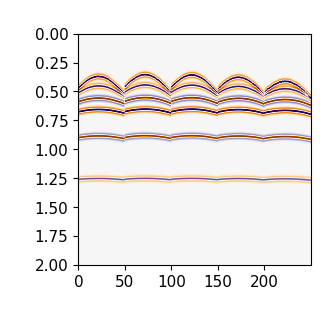

im

In [21]:
uz = irregular_hyperbolic_events(dt,nt,h,tau,vel,amp,f0,fmin,fmax);
SeisPlotTX(uz,wbox=3,hbox=3,oy=0,dy=dt)

In [22]:
# Parameters for ground-roll
fG = 12;
fD = [10.0,20.0];   
vmin = [400.0,600.0];
vmax = [900.0,900.0];
ampx = (1 + rand()) .* [1,-1];
ampz = (1 + rand()) .* [1,-1];

gz = linear_dispersive_events(dt,nt,h,vmin,vmax,ampx,fD,fmin,fmax,fG);
gx = linear_dispersive_events(dt,nt,h,vmin,vmax,ampz,fD,fmin,fmax,fG);     

MethodError: MethodError: no method matching linear_dispersive_events(::Float64, ::Int64, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Int64, ::Int64, ::Int64)
Closest candidates are:
  linear_dispersive_events(::Real, ::Int64, !Matched::AbstractArray{Real,N} where N, !Matched::AbstractArray{Real,N} where N, !Matched::AbstractArray{Real,N} where N, !Matched::AbstractArray{Real,N} where N, !Matched::AbstractArray{Real,N} where N, ::Real, ::Real, ::Real) where T at /home/bbahia/.julia/packages/snr/AqtVx/src/noise/linear_dispersive_events.jl:10

In [23]:
# Observation
d = uz + gz;

UndefVarError: UndefVarError: gz not defined

In [9]:
SeisPlotTX(d,wbox=3,hbox=3,oy=0,dy=dt)

UndefVarError: UndefVarError: d not defined